In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data from CSV file
data = pd.read_csv('../../../Dataset/AKAM_Stock.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

data

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2/1/2019,AKAM,65.519997,65.519997,65.540001,64.500000,65.000000,1426900
1,2/4/2019,AKAM,67.040001,67.040001,67.080002,65.589996,65.589996,1146300
2,2/5/2019,AKAM,68.169998,68.169998,68.300003,67.279999,67.309998,1474300
3,2/6/2019,AKAM,67.510002,67.510002,68.500000,67.480003,68.089996,1379200
4,2/7/2019,AKAM,66.589996,66.589996,67.150002,65.889999,67.110001,1047600
...,...,...,...,...,...,...,...,...
1290,3/19/2024,AKAM,107.790001,107.790001,107.849998,106.809998,107.320000,1326800
1291,3/20/2024,AKAM,109.599998,109.599998,109.639999,107.699997,107.849998,1809500
1292,3/21/2024,AKAM,109.150002,109.150002,110.180000,109.059998,109.669998,1123100
1293,3/22/2024,AKAM,108.970001,108.970001,109.959999,108.550003,109.930000,949700


In [3]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:2:1
df = data
df = df[['Close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [4]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3139.897, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3146.610, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3148.491, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3148.469, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3145.383, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3140.827, Time=0.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3141.856, Time=1.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3143.131, Time=1.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3138.864, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3144.991, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3145.937, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3140.029, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 4.486 seconds


ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [5]:
# 4. Quá trình testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [6]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[110.63648355 110.81403859 110.98327053 111.14474644 111.29899472
 111.44650781 111.58774456 111.72313258 111.85307036 111.97792921
 112.09805516 112.21377067 112.32537622 112.43315183 112.53735842
 112.63823915 112.73602062 112.83091398 112.92311599 113.01281003
 113.10016695 113.18534598 113.26849551 113.3497538  113.42924971
 113.5071033  113.58342647 113.65832349 113.73189151 113.80422109]


In [7]:
# 7. Đánh giá độ chính xác validate, test
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)


Validation RMSE: 6.535841178519419
Testing RMSE: 34.330249914814935


Validation RMSE: 6.535841178519419
Testing RMSE: 34.330249914814935


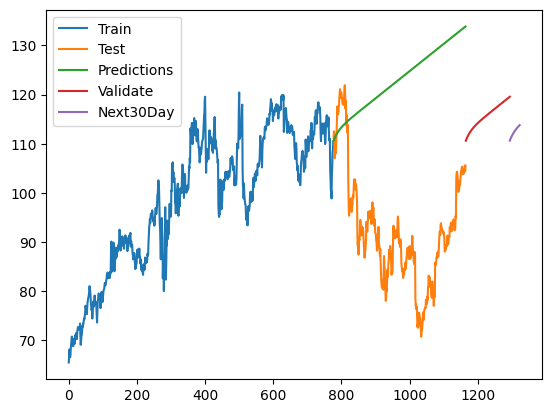

In [8]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

In [9]:
test_data.index

RangeIndex(start=777, stop=1165, step=1)

In [10]:
# Tính MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Tính MDA
def calculate_mda(y_true, y_pred):
    y_true_diff = np.diff(y_true)
    y_pred_diff = np.diff(y_pred)
    correct_direction = np.sign(y_true_diff) == np.sign(y_pred_diff)
    return np.mean(correct_direction) * 100

# Tính toán RMSE, MAPE và MDA
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val) ** 2))
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
valid_mape = calculate_mape(y_val, y_pred_val)
test_mape = calculate_mape(y_test, y_pred)
valid_mda = calculate_mda(y_val, y_pred_val)
test_mda = calculate_mda(y_test, y_pred)

# In kết quả
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)
print('Validation MDA:', valid_mda)
print('Testing MDA:', test_mda)

Validation RMSE: 6.535841178519419
Testing RMSE: 34.330249914814935
Validation MAPE: 4.97076884970169
Testing MAPE: 36.27790731567033
Validation MDA: 53.48837209302325
Testing MDA: 51.162790697674424
